In [1]:
from __future__ import absolute_import, unicode_literals, print_function
import numpy as np
from numpy import pi, cos
import pymultinest as pys
import corner
import numpy as np
import pylab as plt
from scipy.linalg import logm
import corner
import scipy.stats as stat
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection
import copy as COPY
import pandas as pd
plt.style.use('classic')

%matplotlib inline

#%matplotlib nbagg

In [9]:
npix = 200
noise_level = 1
Sources = 		pd.read_csv("/home/hope-moloko/Masters/Masters_Project/source_list5_new.csv")
num_of_model_sources = 5

In [10]:
Sources

,Unnamed: 0,X,Y,R,A
0,0,84.251549,145.872216,4,13.362331
1,1,132.202147,78.564607,4,11.633515
2,2,74.964035,168.064275,4,9.824743
3,3,48.598855,97.242150,4,8.807329
4,4,174.355433,88.047148,4,7.518850


Text(0,0.5,'Y Position')

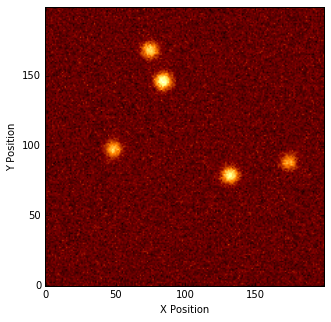

In [11]:
#################### Circularly Gaussian shaped  function ##################
def tau(x,y,X,Y,R,A):  #Circularly  Gaussian Shaped function
    term1 = ((x-X)**2 + (y-Y)**2)/(2*R**2)
    return A*np.exp(-term1)

########################### Source Image ###############################################
x = np.arange(0, npix, 1, float)
y = x [:,np.newaxis]

source1_template = np.zeros((npix,npix))
for i in range(len(Sources)):

    X_true = Sources['X'][i]
    Y_true = Sources['Y'][i]
    R_true = Sources['R'][i]
    A_true = Sources['A'][i]

    source1_template += tau(x,y,X_true,Y_true,R_true,A_true) 



# ADD noise level

noise = 	np.random.normal(0,noise_level,source1_template.shape)
Source = 	source1_template  + noise


plt.figure(figsize=(5,7))
plt.imshow(Source,origin='lower',cmap='afmhot',)
plt.xlabel('X Position')
plt.ylabel('Y Position')

In [18]:
def Model(x,y,Xm,Ym,Rm,Am):  #Model that describes each source
    x = np.arange(0, npix, 1, float)
    y = x[:,np.newaxis]
    
    source_template = np.zeros((npix,npix))
    
    for i in range(len(Xm)):
        
        source_template += tau(x,y,Xm[i],Ym[i],Rm[i],Am[i])
    return source_template


def logLike(cube): #Likelihood function
    cubes = cube.tolist()
    Xm = []
    Ym = []
    Rm = [4,4,4,4,4]
    Am = [11,13,9,8,7]
    for i in range(num_of_model_sources):
        Xm.append(cubes[0])
        Ym.append(cubes[1])
        #Rm.append(cubes[2])
        #Am.append(cubes[3])
        
        cubes.pop(0)
        cubes.pop(0)
        #cubes.pop(0)
        #cubes.pop(0)
        
    
    data = Source
    mu = Model(x,y,Xm,Ym,Rm,Am)
    sigma = noise_level
    term1 = -len(data)*np.log(2*np.pi)/2
    term2 = -(len(data)/2)*np.log(sigma**2)
    term3 = -np.sum((data-mu)**2)/2*(sigma**2)
    
    LogL = term1 + term2 + term3
    
    return LogL 

def mypriors():
    prior_source_list = []
    
    for i in range(num_of_model_sources):
        X_prior = npix*np.random.random()
        Y_prior = npix*np.random.random()
        #R_prior = 4
        #A_prior = 10*np.random.random()+5
        
        prior_source_list.extend([X_prior,Y_prior]) 
    
    return prior_source_list

def plus(x,y):
    if x>y:
        return x+np.log(1+np.exp(y-x))
    
    else:
        return y+np.log(1+np.exp(x-y))

In [20]:
###################Sample N pionts from prior##########################
n = 200  # Number of live points
objects = np.zeros((n,10))
l_objects = np.zeros((n))
for i in range(n):
    objects[i,:] = mypriors()
    l_objects[i] = logLike(cube = objects[i,:])


In [21]:
nest = 10000
keep = np.zeros((nest,10))
logl_sample = []     #Store Log-likelihood of samples
X_sample = []        #Store prior mass
   

mcmc_steps = 10
logWT = []  #Store  weight =width*likelihood


logZ = -1e300     # SUM(weights)= Z Evidence
H = 0

X = 0          # Unit prior mass (Xo = 1)


In [22]:
## MAIN NS LOOP##

#Outer interval 
logw = np.log(1.0 - np.exp(-1.0 / n))
#sigma = mcmc_step_size*np.random.random((ndim))

for i in range(nest):
    # Draw worst object with L* from n points
    worst = np.argmin(l_objects)
    
    #Save worst opbject
    keep[i,:] = objects[worst,:]
    logl_sample.append(l_objects[worst])
    
    #Save prior mass
    X_sample.append(logw)
    
    #Weight
    logwt = logw + l_objects[worst]
    
    
    #Save weight
    logWT.append(logwt)
    
    #Update Evidence Z
    logZnew = plus(logZ,logwt)  
    
    #Update H information
    H = np.exp(logwt-logZnew)*l_objects[worst] \
    +np.exp(logZ-logZnew)*(H+logZ)-logZnew
    
    #Update logZ
    logZ = logZnew
    #Shrink interval
    logw -= 1.0/n 
   

    while True:#----copy a random point and do mcmc from there-----
        copy = np.random.randint(len(objects))
        if (copy != worst):break
            
    objects[worst,:] = COPY.deepcopy(objects[copy,:])
    Likelihood_thresh =  l_objects[copy]
    theta = objects[copy,:]
    sigma = [1.5,1.2,1.2,1.3,1.4,1.2,1.3,1.4,1.2,1.3]                 #[4,5,3,2]
    interval = [0,npix]
    
    
    while True:  #Evolve within current worst likelihood L>L* , draw new point under constraint
        
        new_point = theta + np.random.normal(0,sigma)
        
        Accpt = 0
        for j in range(10):
            
            if (interval[0]<= new_point[j] <= interval[1]):
                Accpt += 1
        
        if Accpt == 10:
            prior = 1
        else: 
            prior = 0
        
        Likelihood_new = logLike(new_point)
    
        
        alpha =  np.exp(-(np.exp(Likelihood_new)-np.exp(Likelihood_thresh))/2)  #np.exp(-(chisq_new-chisq_thresh)/2)
        
        if alpha >= 1:
            objects[worst,:] = new_point  #Replace worst point with new point
            l_objects[worst] = Likelihood_new   #Replace the worst likelihood with new one  
            break
        else:
            u = np.random.uniform()
            if u <= alpha :
                objects[worst,:] = new_point 
                l_objects[worst] = Likelihood_new
                break
            else:
                theta = theta
                
    if i >nest*np.exp(H)/np.log(2.):
        break
        

Z = logZ
Z_err = np.sqrt((H)/n)
H = H        #np.exp(H)/np.log(2.)
print('Evidence Z = {0} +-{1} : Information H = {2} '.format(Z,Z_err,H))

Evidence Z = -30803.027183017195 +-0.511823155411811 : Information H = 52.39258848314057 


In [24]:

#Normalized samples
wt = np.exp((logWT)-max(logWT))
Weights = wt/sum(wt)

#prob_weighted = [(logWT[i]+logl_sample[i])/Z for i in range(nest)]  # CHANGED Logx_same to logWT

#prob = prob_weighted/sum(prob_weighted)

#Effective sample size
#effective_sample_size = int(np.exp(-np.sum(prob*np.log(prob))))
effective_sample_size = int(np.exp(-np.sum(Weights*np.log(Weights+1e-300))))
S = 0
sample = np.zeros((effective_sample_size,10))

# Selecting the Effective sample
while True:
    rnd_point = np.random.randint(len(keep))
    #proba = prob_weighted[rnd_point]/max(prob_weighted)
    proba = Weights[rnd_point]/max(Weights)
    
    if np.random.rand() < proba:
        sample[S,:] = keep[rnd_point,:]
        S += 1
    if S >= effective_sample_size:
        break
print('Effective Sample Size : {}'.format(effective_sample_size))

Effective Sample Size : 12


In [30]:
X_true = Sources['X'][0]
X1_true = Sources['X'][1]

Y_true = Sources['Y'][0]
Y1_true = Sources['Y'][1]

In [27]:
X,X_err,X1,X1_err = np.mean(sample[:,0]),np.std(sample[:,0]),np.mean(sample[:,2]),np.std(sample[:,2])
Y,Y_err,Y1,Y1_err = np.mean(sample[:,1]),np.std(sample[:,1]),np.mean(sample[:,3]),np.std(sample[:,3])

X2,X2_err,X3,X3_err = np.mean(sample[:,2]),np.std(sample[:,2]),np.mean(sample[:,2]),np.std(sample[:,2])
Y2,Y2_err,Y3,Y3_err = np.mean(sample[:,4]),np.std(sample[:,3]),np.mean(sample[:,3]),np.std(sample[:,3])

print('X: {:.3f}-+{:.3f}  X1: {:.3f}-+{:.3f}'.format(X,X_err,X1,X1_err),"|",'X_true : {} X1_true: {}'.format(X_true,X1_true))
print()
print('Y: {:.3f}-+{:.3f}  Y1: {:.3f}-+{:.3f}'.format(Y,Y_err,Y1,Y1_err),"|",'Y_true: {} Y1_true: {}'.format(Y_true,Y1_true))

NameError: name 'X1_true' is not defined

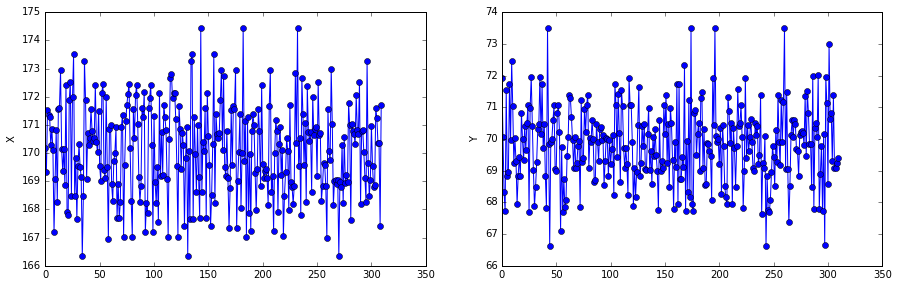

In [24]:
plt.figure(figsize=(15,10))

labels = ['X','Y','X1','Y1']
for i in range(2):
    plt.subplot(2,2,i+1)
    plt.plot(sample[:,i],'-o')
    plt.ylabel(labels[i])
    


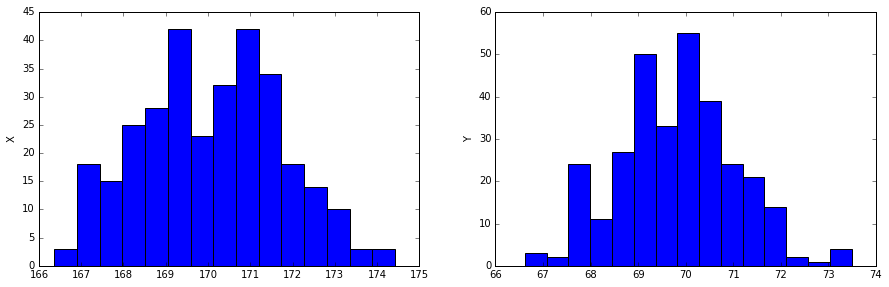

In [25]:
plt.figure(figsize=(15,10))

labels = ['X','Y','X1','Y1']
for i in range(2):
    plt.subplot(2,2,i+1)
    plt.hist(sample[:,i],bins=15)
    plt.ylabel(labels[i])
    


## Trace plots

The two trace plots in each row correspond to a single source with Position X,Y.

#### -  From the trace plots on the left column for the x positons, it can be seen that there is a clear convergence (i.e finding an x position of one source) but at some point there's a jump from one mode to the other and back again??

#### - The same result can be seen on the right column of the Y positions.
    

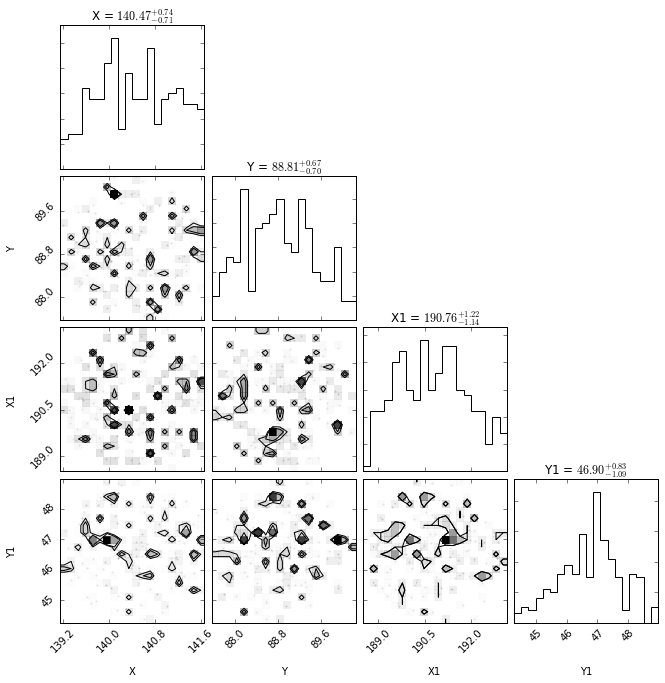

In [41]:
corner.corner(sample,labels=['X','Y','X1','Y1'],show_titles=True,bins=20,levels=[0.5,0.65],truths=[20,15,45,32]);


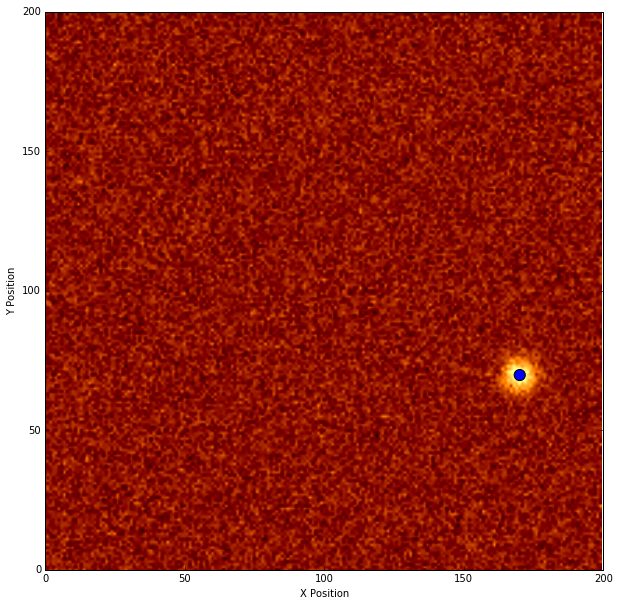

In [26]:
plt.figure(figsize=(10,15))
ax = plt.gca()
ellipses = []
plt.xlim([0,npix])
plt.ylim([0,npix])
X_pos = [X,X1]
Y_pos = [Y,Y1]
for ra, dec in zip(X_pos,Y_pos):
    ellipse = Ellipse(xy=(ra, dec), width=4, height=4, angle=0)
    ellipses.append(ellipse)

p = PatchCollection(ellipses)
ax.add_collection(p)
plt.imshow(Source,origin='lower',cmap='afmhot',)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()

## The circles in blue are the estimated positions X,Y of the sources.